Everything here is the same as `deberta_base_fresh.ipynb`, except that BERT replaces DeBERTa

# Imports

In [1]:
!nvidia-smi

Sat Dec  3 23:29:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers --quiet
!pip install sentencepiece --quiet

In [3]:
import os
import sys
import time
import string
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, \
  LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer
from transformers import BertConfig, BertTokenizer, TFBertModel
import transformers

## Global Variables and Google Drive Connect

In [4]:
TESTING = False # use to truncate training data in order to speed up development

RANDOM_STATE = 42
SEQUENCE_LENGTH = 512
BATCH_SIZE = 1
USER = 'Tom'
RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
PATIENCE = 2
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = 0.01
EPOCHS = 4
# Uncomment these two lines if you want to be able to be able to repeat calculations exactly on the same hardware
# However, the model will run more slowly (approx 1/3 speed)
# tf.keras.utils.set_random_seed(RANDOM_STATE)
# tf.config.experimental.enable_op_determinism()

In [5]:
# Mount drive where you will do your work.
drive.mount('/content/drive')
if USER == 'Alex': 
  root_dir = "/content/drive/MyDrive/w266/"
  project_folder = "Final_Project/"
elif USER == 'Kurt':
  root_dir = "/content/drive/My Drive/266/"
  project_folder = "Final Project/"
elif USER == 'Tom':
  root_dir = "/content/drive/My Drive/UC Berkeley/W266 Natural Language Processing/"
  project_folder = "Final Project/"
else:
  raise Exception("User unrecognized, must connect to shared drive")

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # to test if all is working, you can uncomment these two lines below--it should write a file to the shared drive
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

os.chdir(root_dir + project_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data and Create Data Sets

In [6]:
#Pull training data with all columns
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')

#pull validation data with all columns 
X_val = pd.read_csv('data/processed/X_val.csv')
y_val = pd.read_csv('data/processed/y_val.csv')

#pull test data with all columns
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv')

#drop all non-text columns and concatenate train and val into one dataset
train_data = pd.merge(X_train, y_train, on='essay_index', how='outer')
validation_data = pd.merge(X_val, y_val, on='essay_index', how='outer')
test_data = pd.merge(X_test, y_test, on='essay_index', how='outer')

#create train set
train_data = train_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
train_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#create val set
val_data = validation_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
val_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#create test set
test_data = test_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
test_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

print("train data size is: {}".format(train_data.shape))
print("val data size is: {}".format(val_data.shape))
print("test data size is: {}".format(val_data.shape))

train data size is: (2347, 7)
val data size is: (782, 7)
test data size is: (782, 7)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
if TESTING:
  train_size = 250
  val_size = 3

  print("=========================================\nIN TESTING MODE\n=========================================")

else:
  train_size = 2347
  val_size = 782

train_data = train_data[:train_size]
val_data = val_data[:val_size]

print("input_data size is: {}".format(train_data.shape))
print("validation data size is: {}".format(val_data.shape))

input_data size is: (2347, 7)
validation data size is: (782, 7)


In [8]:
train_data

,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,Has there been anyone in your life that shared...,4.0,3.5,3.5,3.5,3.0,3.5
1,There is a debate today day about whether the ...,3.0,3.0,4.0,3.0,4.0,4.0
2,Do you agree or disagree with extending the sc...,4.0,4.5,4.0,4.0,4.5,5.0
3,"""Unless you try to do something beyong what yo...",2.0,2.0,3.0,2.5,2.5,2.0
4,Are you one of the students that is home schoo...,3.0,3.0,3.0,3.0,3.0,3.5
...,...,...,...,...,...,...,...
2342,Online schools is a good idea but not for ever...,3.0,3.0,3.0,3.0,4.0,3.0
2343,Do you want to know how a science could be enj...,3.5,3.0,3.0,3.0,3.5,3.5
2344,Has the limitation of human contact due to the...,3.0,4.0,3.5,3.5,3.5,3.0
2345,Technology had positives effects in people liv...,3.5,3.0,3.5,3.0,3.0,3.0


## Tokenize Data

In [9]:
# bert_model = AutoModel.from_pretrained("microsoft/bert-v3-base")
# bert_tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/bert-v3-base")

bert_model = transformers.TFAutoModel.from_pretrained('bert-base-cased') # changed from deberta_base_fresh
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased') # changed from deberta_base_fresh

auto_tune = tf.data.experimental.AUTOTUNE

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [10]:
def bert_encode(texts, tokenizer, attn_mask):
    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=SEQUENCE_LENGTH, 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    if attn_mask:
      return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")
    else:
      return np.array(input_ids, dtype="int32")


def get_data(df, attn_mask=True):
    inputs = bert_encode(df['full_text'], bert_tokenizer, attn_mask)  # changed
    targets = np.array(df[RUBRIC_COLS], dtype="float32")
    return inputs, targets

In [11]:
# create dataset constructs for use in pipeline
train_dataset = get_data(train_data)
val_dataset = get_data(val_data)
test_dataset = get_data(test_data)

# Loss and Metrics Functions

In [12]:
# Using Huber loss which is less sensitive to outliers/edge cases
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

keras.losses.huber_loss = huber_loss

In [13]:
# Custom metric function MCRMSE : column wise root mean squared eoor
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# Callbacks and LR 

In [14]:
#early stopping
earlystopper = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience = PATIENCE,
      restore_best_weights=True)

In [15]:
#learning rate schedule
def lr_scheduler(epoch, lr):
    
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Model Configurations

In [16]:
base_bert_config = dict(
    # RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
    #                'phraseology', 'grammar', 'conventions'],
    batch_size = BATCH_SIZE,
    model_name = 'base_bert',
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = [MCRMSE],
    earlystopping_patience = PATIENCE
)

In [17]:
cfg = transformers.AutoConfig.from_pretrained("bert-base-cased", output_hidden_states=True) # Changed from deberta_base_fresh
cfg.hidden_dropout_prob = 0
cfg.attention_probs_dropout_prob = 0
# cfg.save_pretrained('./tokenizer/')

## BERT Experiments

#### BERT with pooled output

In [18]:
def create_bert_model(bert_model,
                      train_layers = -1,
                      hidden_size = 100, 
                      dropout = 0.0):

    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        # If frozen, then only layers placed ontop of BERT will be trained
        bert_model.trainable = False

    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
            
        
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    # Read in bert model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks
    )
    hidden_states = bert_output.last_hidden_state

    x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
    x = tf.keras.layers.LayerNormalization()(x)

    # # Prediction layer - predict all 6 analytic measures
    output = tf.keras.layers.Dense(6, name='prediction_layer')(x)

    # # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=MCRMSE)
       
    return model

# Building Models

In [19]:
#ex 1
tf.keras.backend.clear_session()

bert_model = transformers.TFAutoModel.from_pretrained("bert-base-cased", config=cfg)
bert_pooled_model = create_bert_model(bert_model,
                                                 train_layers = -1,
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

tf.keras.backend.clear_session()

gc.collect()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


23209

# Training Models

In [20]:
def train_model(model,
                train_df,
                val_df,
                config: dict,
                callbacks: list,
                verbose: int=0):
  
    # Initalize model
    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = PATIENCE , restore_best_weights=True)

    model_history = model.fit(
      x=train_df[0],
      y=train_df[1],
      validation_data = val_df,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      shuffle = True, 
      callbacks = [callback]
      )

    return model_history

In [21]:
%%time
callbacks = [earlystopper]

tf.keras.backend.clear_session()

model_history = train_model(model=bert_pooled_model,
                        train_df = train_dataset, 
                         val_df = val_dataset, 
                         config=base_bert_config, 
                         callbacks=callbacks, 
                         verbose=1)

tf.keras.backend.clear_session()

Epoch 1/4
2347/2347 [==============================] - 40s 14ms/step - loss: 1.0460 - MCRMSE: 1.4521 - val_loss: 0.3085 - val_MCRMSE: 0.6564
Epoch 2/4
2347/2347 [==============================] - 32s 14ms/step - loss: 0.2863 - MCRMSE: 0.6295 - val_loss: 0.2456 - val_MCRMSE: 0.5746
Epoch 3/4
2347/2347 [==============================] - 33s 14ms/step - loss: 0.2333 - MCRMSE: 0.5603 - val_loss: 0.2100 - val_MCRMSE: 0.5262
Epoch 4/4
2347/2347 [==============================] - 31s 13ms/step - loss: 0.2032 - MCRMSE: 0.5187 - val_loss: 0.1902 - val_MCRMSE: 0.5004
CPU times: user 2min 40s, sys: 8.5 s, total: 2min 49s
Wall time: 2min 16s


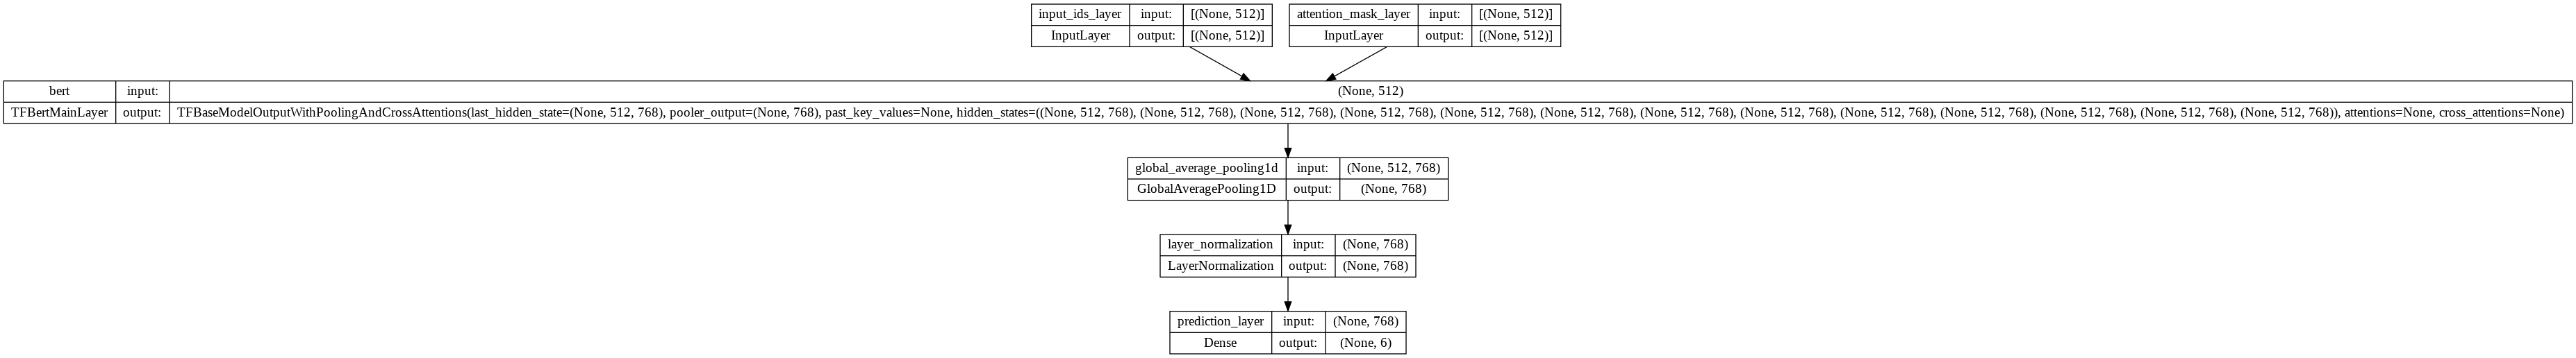

In [22]:
plot_model(bert_pooled_model, show_shapes=True, show_layer_names=True)

In [23]:
bert_pooled_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids_layer[0][0]',        
                                thPoolingAndCrossAt               'attention_mask_layer[0][0]']   
                                tentions(last_hidde                                           

In [24]:
# bert_pooled_model.save('models/bert_base_fresh_frozen_many_epochs')

In [25]:
# saved_bert_model = tf.keras.models.load_model('models/bert_base_fresh_frozen_many_epochs', custom_objects={'MCRMSE':MCRMSE})
saved_bert_model = bert_pooled_model

# Evaluation

In [26]:
results = saved_bert_model.evaluate(train_dataset[0], train_dataset[1], batch_size=BATCH_SIZE)
print("Train Set--------Huber loss:", results[0], "   MCRMSE:", results[1])

2347/2347 [==============================] - 23s 10ms/step - loss: 0.1928 - MCRMSE: 0.5039
Train Set--------Huber loss: 0.19279633462429047    MCRMSE: 0.5039222836494446


In [27]:
results = saved_bert_model.evaluate(val_dataset[0], val_dataset[1], batch_size=BATCH_SIZE)
print("Validation Set---Huber loss:", results[0], "   MCRMSE:", results[1])

782/782 [==============================] - 8s 10ms/step - loss: 0.1902 - MCRMSE: 0.5004
Validation Set---Huber loss: 0.19024263322353363    MCRMSE: 0.5004469156265259


In [28]:
results = saved_bert_model.evaluate(test_dataset[0], test_dataset[1], batch_size=BATCH_SIZE)
print("Test Set---------Huber loss:", results[0], "   MCRMSE:", results[1])

782/782 [==============================] - 8s 10ms/step - loss: 0.1941 - MCRMSE: 0.5080
Test Set---------Huber loss: 0.19408731162548065    MCRMSE: 0.5079578161239624
